In [1]:
import torch 
from diffusers import UNet2DModel, DDIMPipeline, DDPMScheduler
from pipelines import TS_DDIMPipeline

results_dir = "/data/users/igeorvasilis/ddpm_cl/cifar10" 

In [2]:
pretrained_model_dir = f"{results_dir}/b32/no_mask/0/epoch-200"
# pretrained_model_dir = f"{results_dir}/b32/mask/m0/epoch-200"

gen_seed = torch.manual_seed(0)

In [3]:
# Define the UNet model
model = UNet2DModel(
    sample_size=32,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=[128,128,256,256,512,512],
    down_block_types=["DownBlock2D","DownBlock2D","DownBlock2D","DownBlock2D","AttnDownBlock2D","DownBlock2D"],  # the number of output channels for each UNet block
    up_block_types=["UpBlock2D","AttnUpBlock2D","UpBlock2D","UpBlock2D","UpBlock2D","UpBlock2D"],
)

model = UNet2DModel.from_pretrained(
    pretrained_model_dir, subfolder="unet", use_safetensors=True)
    
# Move the model to the device
model = model.to('cuda:0')

In [4]:
# Define the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=.02,
    beta_schedule="squaredcos_cap_v2"
)

# Load pretrained noise scheduler if args.pretrained_model_dir is not None
noise_scheduler = DDPMScheduler.from_pretrained(
    pretrained_model_dir, subfolder="scheduler", use_safetensors=True)

In [5]:
# Define the pipeline
# pipeline = DDIMPipeline(unet=model, scheduler=noise_scheduler)
pipeline = TS_DDIMPipeline(unet=model, scheduler=noise_scheduler, labels=[0])
pipeline.set_progress_bar_config(disable=True)

(-0.5, 255.5, 127.5, -0.5)

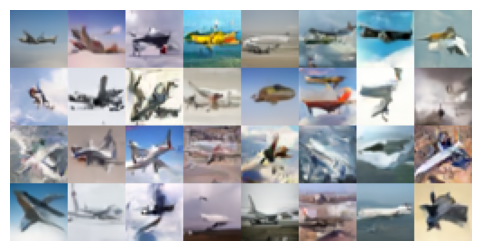

In [6]:
import matplotlib.pyplot as plt
from diffusers.utils import make_image_grid

bs = 32
    
with torch.no_grad():
    # Generate images
    images = pipeline(
        batch_size=bs,
        num_inference_steps=50,
        generator=torch.manual_seed(0),
    ).images

# Save the images
image_grid = make_image_grid(images[:bs], rows=4, cols=8)
plt.figure(figsize=(6, 3))
plt.imshow(image_grid)
plt.axis("off")